# Learning Aerial Image Segmentation From Online Maps
## uses Unet[2] network, and Dice Loss[3]

### References:
[1] https://ieeexplore.ieee.org/document/7987710 <br/>
[2] https://arxiv.org/abs/1505.04597 <br/>
[3] https://arxiv.org/abs/1707.03237

### Download dataset from here: https://zenodo.org/record/1154821/#.XuylkJ4zadY or use the code below

In [ ]:
 # Download an unzip the dataset first 
!wget https://zenodo.org/record/1154821/files/berlin.zip
!unzip -q berlin.zip
!wget https://zenodo.org/record/1154821/files/chicago.zip
!unzip -q chicago.zip
!wget https://zenodo.org/record/1154821/files/paris.zip
!unzip -q paris.zip
!wget https://zenodo.org/record/1154821/files/zurich.zip
!unzip -q zurich.zip

## Exploration of the dataset


Giving a look through the dataset, some problems were found.<br/>
1) Images are seen to be weekly labled.<br/>
    a) Road masks is not proper. <br/> 
    b) Missed building anotation.<br/>
    c) Completly wrong annotation <br/>
    Reasons: Human error and/or there has been a construction work later (maps outdated).<br/>

2) Road boundaries not marked clearly in images. <br/>

In [23]:
# general variables instantiated
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
label_blg = [255,0,0]
label_road = [0,0, 255]
label_bg = [255,255,255]
shape= (340,340,3)
labels_encoded = np.array([label_blg, label_road, label_bg]) // 255
labels_name = ['Building', 'Road', 'Background']
random_seed = 666

In [24]:
# overlays mask over image
# also works when rgb numpy array is passed instead of filename
# returns RGB
import numpy as np
import cv2
def overlay(img, msk, alpha=1):
    import matplotlib.pyplot as plt
    if not isinstance(img, np.ndarray):
        image = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(msk),cv2.COLOR_BGR2RGB)
    else:
        image = img.copy()
        mask = msk.copy()
    # find indexes with background pixels
    indexes = np.where((mask==label_bg).all(axis=2))
    mask[indexes] = image[indexes]
    cv2.addWeighted(mask, alpha, image, 1-alpha, 0, image)
    plt.axis('off')
    plt.imshow(image)

1 a) Road masks is not proper


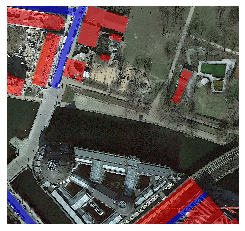

1 b) Missed building anotation on some parts of the image


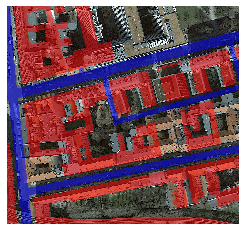

1 c) Completely wrong annotation


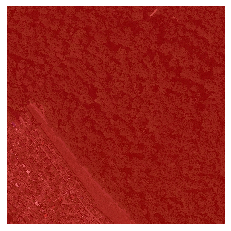

2) Road boundaries not marked clearly in images
In the below image the roads that are not highways are marked thinner 
compared to highways even though more width is clearly visible


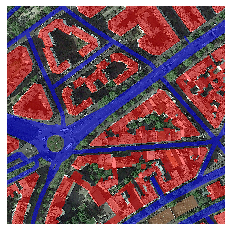

In [17]:
import matplotlib.pyplot as plt
print('1 a) Road masks is not proper')
image_file = 'berlin/berlin189_image.png'
mask_file = 'berlin/berlin189_labels.png'
overlay(image_file, mask_file, alpha=0.5)
plt.show()
print('1 b) Missed building anotation on some parts of the image')
image_file = 'berlin/berlin185_image.png'
mask_file = 'berlin/berlin185_labels.png'
overlay(image_file, mask_file, alpha=0.5)
plt.show()
print('1 c) Completely wrong annotation')
image_file = 'zurich/zurich225_image.png'
mask_file = 'zurich/zurich225_labels.png'
overlay(image_file, mask_file, alpha=0.5)
plt.show()
print('2) Road boundaries not marked clearly in images\nIn the below image the roads that are not highways are marked thinner \ncompared to highways even though more width is clearly visible')
image_file = 'paris/paris30_image.png'
mask_file = 'paris/paris30_labels.png'
overlay(image_file, mask_file, alpha=0.5)
plt.show()


## Check pixel imbalance

In [25]:
# returns rgb normalised image
from tqdm import tqdm
def read_resize_img(file, shape):
    img = cv2.imread(file)
    img = cv2.resize(img, (shape[0], shape[1]))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)//255

# returns a dictionary of image name and count of labels per image in a folder
import glob
def get_classes_count_per_image(folder, labels_encoded, shape):
    files = glob.glob(folder)
    data = {}
    with tqdm(total=len(files)) as pbar:
        for i,file in enumerate(files):
            val = np.empty((len(labels_encoded)), dtype=int)
            img = read_resize_img(file, shape)
            for j, label in enumerate(labels_encoded):
                val[j] = np.count_nonzero((img==label).all(axis=2))
                data[file] = val.copy()   
            pbar.update()
    return data 

In [19]:
import sys
!{sys.executable} -m pip install -q tqdm
print('tqdm installed.')

tqdm installed.


In [26]:
# prepare data for analysis
# get labels count for each city
folders_y = ['berlin/*_labels.png', 'chicago/*_labels.png', 'paris/*_labels.png', 'zurich/*_labels.png']
# save data to dictionary for easy access
data_dict = {}
for folder in folders_y:
    data_dict[folder]= get_classes_count_per_image(folder, labels_encoded, shape)

100%|██████████| 364/364 [00:51<00:00,  7.01it/s]


[]

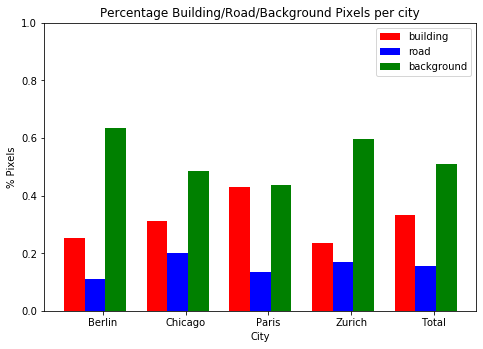

In [27]:
# preparing data to plot
data = np.empty((len(labels_encoded), len(folders_y)), dtype=int)
data[:, 0] = np.array(list(data_dict['berlin/*_labels.png'].values())).sum(axis=0)
data[:, 1] = np.array(list(data_dict['chicago/*_labels.png'].values())).sum(axis=0)
data[:, 2] = np.array(list(data_dict['paris/*_labels.png'].values())).sum(axis=0)
data[:, 3] = np.array(list(data_dict['zurich/*_labels.png'].values())).sum(axis=0)
#append total row
data = np.append(data, data.sum(axis=1).reshape(-1,1), axis=1)
# normalise the data
data_plot = data / data.sum(axis=0)

# show the label balance within the data
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(5)
bar_width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data_plot[0], color = 'r', width = 0.25, label='building')
ax.bar(X + 0.25, data_plot[1], color = 'b', width = 0.25, label='road')
ax.bar(X + 0.50, data_plot[2], color = 'g', width = 0.25, label='background')
plt.xlabel('City')
plt.ylabel('% Pixels')
plt.title('Percentage Building/Road/Background Pixels per city')
plt.xticks(X + bar_width, ('Berlin', 'Chicago', 'Paris', 'Zurich', 'Total'))
plt.legend()
plt.ylim([0, 1])
plt.plot()

It can be seen from above that our data is not balanced. When compared to whole data, no. of road labels are almost half of that of building labels. <br/>
So lets check how our data is distributed, this can give us a clue where to reject some outliers during training.<br/>
**Trying some boxplots to see the distribution.**

/home/dutta/.conda/envs/base_clone/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/dutta/.conda/envs/base_clone/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[]

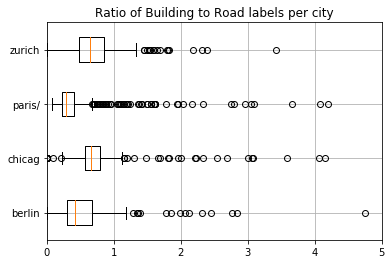

In [28]:
# find ratio building to road labels in images, ignore background
ratios = []
colum_names = []
for key in data_dict.keys():
    data = np.array(list(data_dict[key].values()))
    ratio = data/data[:,0].reshape(-1,1)
    ratios.append(np.nan_to_num(ratio[:,1]))
    colum_names.append(key[0:6])
    
plt.xlim(0,5)
plt.title('Ratio of Building to Road labels per city')
plt.grid()
plt.boxplot(ratios, labels=colum_names, vert=False)
plt.plot()

1. From the barchart, it can be seen that on an average, no. of road labels are almost half of that of building labels, and building labels are half of that of background labels. This tells it is an **unbalanced dataset** problem. One of the way to tackle this is by **adding weights to loss function** during training of the model.<br/> 
2. Looking through this boxplot, we can see there are a few **outliers**. We can put a threshold of building/road pixels < 1.4 for overall. We donot train those samples whose building/road pixels ration is greater than 1.4. Individual thresholding is also possible.<br />


In [29]:
# check pixel imbalance in label images
# get blue : red ratio
import cv2
import numpy as np
def get_class_balance(np_cv_img):
    # opencv uses b,g,r mapping
    b,g,r = cv2.split(np_cv_img)
    count_blue_pixels = np.count_nonzero(b)
    count_red_pixels = np.count_nonzero(r)
    
    return count_blue_pixels / count_red_pixels

# test method
img = cv2.imread('berlin/berlin100_labels.png')
print(get_class_balance(img))

0.6218015019383567


### Train a segmentation model

### Create a DataLoader.  
It's responsibilities are <br/>
1. Split the data into train and validation during training.<br/>
2. Apply any checks to the data, for e.g., add thresholds to accept or reject training samples.<br/>
3. Prepare in a format for DataGenerator to consume. (DataGenerator coming next)

In [32]:
import glob
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split as split

'''
Takes list of image folders and mask folders and required shape to process any image.
Specifiy test size for data split, threshold_range for balancing dataset
'''
class DataLoader:

    def __init__(self, folders_x, folders_y, shape, test_size=0.2, 
                 threshold_range=None, seed=666):
        self.folders_x = folders_x
        self.folders_y = folders_y
        self.test_size = test_size
        self.shape = shape
        if threshold_range is not None:
            self.check_balanced = True
            self.threshold_range = threshold_range
        if self.check_balanced:
            print('DataLoader will check for balanced images, it will take some time...')
        random.seed(seed)
        print('DataLoader initialised.')

    def __check_if_balanced_class__(self, img_path):
        np_cv_img = cv2.imread(img_path)
        np_cv_img = cv2.resize(np_cv_img, (self.shape[0], self.shape[1]))
        val = get_class_balance(np_cv_img)
        if self.threshold_range[0] <= val <= self.threshold_range[1]:
            return True

    def __remove_imbalanced__(self, x_dict, y_dict):
        x, y = {}, {}
        with tqdm(total=len(y_dict)) as pbar:
            for key in y_dict.keys():
                if not self.check_balanced or self.__check_if_balanced_class__(y_dict[key]):
                    x[key] = x_dict[key]
                    y[key] = y_dict[key]
                pbar.update()

        return x, y

    # internal function to generate mapping
    def __populate_files_dict__(self, path):
        files = glob.glob(path)
        file_dict = {}
        for file in files:
            loc = file.rfind('_')
            file_dict[file[0:loc]] = file
        return file_dict

    # gives output as dictionaries of test and train data
    def get_train_test_split(self):
        # get all the data
        x_dict, y_dict = {}, {}
        for folder_x, folder_y in zip(folders_x, folders_y):
            # print('reading {0} / {1}'.format(folder_x, folder_y))
            x = self.__populate_files_dict__(folder_x)
            y = self.__populate_files_dict__(folder_y)
            x, y = self.__remove_imbalanced__(x, y)
            assert (len(x) == len(y))
            x_dict.update(x)
            y_dict.update(y)
            print('Usable :{}'.format(len(x)))

        # got all the data, time to split
        list_keys = list(x_dict.keys())
        random.shuffle(list_keys)
        train_keys, test_keys = split(list_keys, test_size=self.test_size, random_state=42)
        # got the keys, now create individual dictionaries
        images_train_dict = {key: x_dict[key] for key in train_keys}
        labels_train_dict = {key: y_dict[key] for key in train_keys}
        images_test_dict = {key: x_dict[key] for key in test_keys}
        labels_test_dict = {key: y_dict[key] for key in test_keys}

        return images_train_dict, labels_train_dict, images_test_dict, labels_test_dict


## Train / test Data split is 80/20, considering samples whose building : road labels are in the range 0.6 - 1.4.

In [33]:
folders_x = ['berlin/*_image.png', 'chicago/*_image.png', 'paris/*_image.png', 'zurich/*_image.png']
folders_y = ['berlin/*_labels.png', 'chicago/*_labels.png', 'paris/*_labels.png', 'zurich/*_labels.png']

data_loader = DataLoader(folders_x, folders_y, shape, threshold_range=(0.6,1.4), seed=random_seed)
images_train_dict, labels_train_dict, images_test_dict, labels_test_dict = data_loader.get_train_test_split()

  0%|          | 0/200 [00:00<?, ?it/s]

DataLoader will check for balanced images, it will take some time...
DataLoader initialised.


  0%|          | 0/457 [00:00<?, ?it/s]

Usable :196


  0%|          | 1/625 [00:00<01:13,  8.49it/s]

Usable :442


  0%|          | 1/364 [00:00<00:49,  7.35it/s]

Usable :348


100%|██████████| 364/364 [00:34<00:00, 10.49it/s]

Usable :338


## Create DataGenerator that will feed data to the learning model
Responsibilities of DataGenerator are <br/>

1. Generate normalised image and mask for the learning model as per batch_size configured. <br/>
2. Augment the data as per augmentation configurations passed.<br/>
3. Can also add different sets of augmentation for image and mask. For e.g., adding brightness/noise to image, but not the mask.<br/>
4. Generate data in the format the learning model can use.

In [34]:
def pre_process_img(img, shape):
    image = cv2.resize(img, (shape[0], shape[1]))
    return np.expand_dims(image, axis=0)


def normalise_img(img):
    # img = img.astype(np.float32)
    # min = img.min()
    # max = img.max()
    # x = 2.0 * (img - min) / (max - min) - 1.0
    return img / 255.


import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import keras
import cv2
import random


# responsible for generating data in batches for the fit_generator function
class DataGenerator(keras.utils.Sequence):

    def __getitem__(self, index):
        if self.augment:
            indexes = self.indexes[index]
            self.__augment_batches__(indexes)
        else:
            # no augmenting here
            indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
            files_x = [self.images_dict[k] for k in indexes]
            files_y = [self.label_dict[k] for k in indexes]
            # populate the batches to return
            self.__populate_batches__(files_x, self.images_batch_x, normalise=self.normalise)
            self.__populate_batches__(files_y, self.images_batch_y)

        self.__mask_to_labels__(self.images_batch_y // 255)
        return self.images_batch_x, self.images_batch_labels

    def __len__(self):
        return len(self.indexes)

    def __mask_to_labels__(self, masks_batch):

        for i, msk in enumerate(masks_batch):
            mask_label = np.ones((msk.shape[0], msk.shape[1])) * -1
            for j, cls in enumerate(self.classes):
                indx = np.where((msk == self.labels[j]).all(axis=2))
                mask_label[indx] = cls
            masks = [(mask_label == v) for v in self.classes]
            mask = np.stack(masks, axis=-1).astype(np.float32)
            self.images_batch_labels[i] = mask.copy()

    def __augment_batches__(self, index):

        img = cv2.imread(self.images_dict[index])
        img = pre_process_img(img, self.shape)
        msk = cv2.imread(self.label_dict[index])
        msk = pre_process_img(msk, self.shape)
        # generate augmented images for each x and y
        self.__generate_images__(img, self.images_batch_x, self.augmenter_x, normalise=self.normalise)
        self.__generate_images__(msk, self.images_batch_y, self.augmenter_y)

    # augmenter in work here
    def __generate_images__(self, image, out_variable, augmenter, normalise=False):
        augmenter.fit(image)
        # use same seed to put exactly same augmentations
        image_iterator = augmenter.flow(image, batch_size=self.batch_size, seed=self.seed)
        for j in range(self.batch_size):
            image_x = image_iterator.next()[0].copy()
            if normalise:
                image_x = normalise_img(image_x)
            out_variable[j] = image_x

    def __populate_batches__(self, file_names, var, normalise=False):
        i = 0
        for file in file_names:
            img_b = cv2.imread(file)
            img_b = cv2.resize(img_b, (self.shape[0], self.shape[1])).copy()
            if normalise:
                img_b = normalise_img(img_b)
            var[i] = img_b
            i += 1

    def __init__(self, batch_size, shape, images_dict, labels_dict, labels, 
                 aug_x_params=None, aug_y_params=None,
                 normalise=True, seed=666):
        assert (len(images_dict) > batch_size > 0)
        assert (len(shape) == 3)
        assert (len(images_dict) == len(labels_dict))
        self.batch_size = batch_size
        self.shape = shape
        self.images_dict = images_dict
        self.label_dict = labels_dict
        self.aug_x_params = aug_x_params
        self.aug_y_params = aug_y_params
        self.augment = False
        if self.aug_y_params or aug_y_params is not None:
            self.augment = True
        if self.aug_x_params is None:
            self.aug_x_params = {}
        if self.aug_y_params is None:
            self.aug_y_params = {}
        self.augmenter_x = ImageDataGenerator(**self.aug_x_params)
        self.augmenter_y = ImageDataGenerator(**self.aug_y_params)
        self.classes = list(np.arange(len(labels)))
        self.labels = labels
        # should the data be normalised when generated
        self.normalise = normalise
        self.seed=seed
        random.seed(seed)
        # placeholders for batch processing
        self.images_batch_x = np.empty((batch_size, shape[0], shape[1], shape[2]), dtype=np.float32)
        self.images_batch_y = np.empty((batch_size, shape[0], shape[1], shape[2]), dtype=np.float32)
        self.images_batch_labels = np.empty((batch_size, shape[0], shape[1], 3), dtype=np.uint8)
        self.indexes = np.array(list(self.images_dict.keys()))
        print('DataGenerator initialised with augmenting is', self.augment)

/home/dutta/.conda/envs/base_clone/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [35]:
# add preprocessing functions not available to keras ImageDataGenerator
import random
def add_preprocessing(img):
    # aadding gaussian blur for 30% of the images
    def add_gaussian_blur(img):
        if( random.random() < 0.3):
            return cv2.GaussianBlur(img,(5,5),0)
        return img
    
    img = add_gaussian_blur(img)
    return img

DataGenerator initialised with augmenting is True


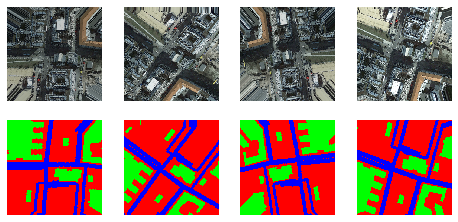

In [37]:
# let's visualise some images from the DataGenerator
# The DataGenerator returns normalised image and coded mask, and hence this mask doesn't resemble original mask
import matplotlib.pyplot as plt
batch_size = 4
aug_x = dict(rotation_range=90,
           brightness_range=(0.7,1.5),
            zoom_range=0.1,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=add_preprocessing,
            fill_mode="nearest")

aug_y = dict(rotation_range=90,
            zoom_range=0.1,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="nearest")
data_gen = DataGenerator(batch_size, (256,256,3), images_train_dict, labels_train_dict, 
                          labels_encoded, normalise=True, aug_x_params=aug_x, 
                          aug_y_params=aug_y)
images, masks = data_gen[0]

def plot(images, size, masks=None, apply_fn=None):
    if masks is not None:
        imgs = np.vstack((images,masks))
        iter =  2*size
    else:
        imgs = images
        iter = size
    fig = plt.figure(figsize=(8, 8))
    for i in range(1,iter+1):
        ax = fig.add_subplot(size, size, i)
        img = cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB)
        if apply_fn is not None:
            img = apply_fn(img)
        ax.imshow(img)
        plt.axis('off')
        
plot(images, batch_size, masks)


## Train a segmentation model

###Model used : **Unet EfficientNetB3** - 
- Unet is a fully convolutional Neural Network that was originally developed for bio medical image segmentation. 
- Unet consists of two parts, downsampling part which extracts features and upsampling part to localise patterns in image. Skip connections are added between downsampling and upsampling to allow precise location and context.
- Unet architecture allows different backbone in encoder path to be used with appropiate modifications in decoder path. I used EfficientNetB3 as the backbone.
- Unet was shown to work well with limited data (but with high augmentation).

**Augmentation parmeters used**

- The number of data images were not sufficient and can easily overfit the model. Hence data augmentation was needed. 
- Different augmentation parameters were used. Some of the augmentations are applied to both images and mask whereas few are applied only to the image.  
- Common augmentations : 
        - zooming a little, height and width shifting with nearest fill, horizontal / vertical flipping the images and masks  and shearing images by a small factor. Applying these augmentations can generalise more data from exisiting data without compromising in quality.
- Augmentation only to images (not to masks): 
        - adding brightness range, gaussian blur. These cannot be applied to mask as mask are irrespective of blur and brightness factor.

**Hyperparameters used**
- *Dice loss function* : The dataset is imbalanced as shown before. Hence used dice loss with weights. More priority was given in learning the roads which were least in the dataset, and least priority was given to the background which was in abundance.
- *Imagenet encoder weights* and *adam optimiser* used with small *learning rate (0.0001)*, because I am using transfer learning. 



In [17]:
def dice_loss_function():
    return sm.losses.DiceLoss(class_weights=np.array([1, 1, 0.5]))
import segmentation_models as sm
def create_model(shape, n_classes=3):
    assert (len(shape) == 3)
    assert(n_classes > 1)
    optimizer = keras.optimizers.Adam(0.0001)
    dice_loss = dice_loss_function()
    keras.backend.set_image_data_format('channels_last')
    model = sm.Unet('efficientnetb3', input_shape=(shape[0], shape[1], shape[2]), classes=n_classes,
                    activation='sigmoig', encoder_weights='imagenet')
    metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    model.compile(optimizer, dice_loss, metrics)
    print('Model created.')

    return model

Segmentation Models: using `keras` framework.


In [18]:
def create_callbacks(check_point_path):
    from keras.callbacks import ModelCheckpoint, Callback
    checkpoint_file = str(check_point_path) 
    checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss',
                                 save_best_only=True)
    print('callbacks created.')

    return [checkpoint]

In [19]:
epochs = 15
shape = (320, 320, 3)
batch_size = 16
checkpoint_path = 'ml_model.h5'

# different sets of augmentation created for i/p and o/p images
aug_x = dict(rotation_range=90,
            brightness_range=(0.7,1.5),
            zoom_range=0.1,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=add_preprocessing,
            fill_mode="nearest")

aug_y = dict(rotation_range=90,
            zoom_range=0.1,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="nearest")

train_data_gen = DataGenerator2(batch_size, shape, images_train_dict, labels_train_dict, 
                                labels_encoded, normalise=True,
                                aug_x_params=aug_x, aug_y_params=aug_y)
# do not augment test generator
test_data_gen = DataGenerator2(batch_size, shape, images_test_dict, labels_test_dict, 
                               labels_encoded, normalise=True)
#check it there is an already existing model
import os.path
if os.path.isfile(checkpoint_path):
    from keras.models import load_model
    print('existing model found, loading it...')
    model = load_model(checkpoint_path, custom_objects={'dice_loss': sm.losses.DiceLoss(class_weights=np.array([1, 1, 0.5]))})
else:
    model = create_model(shape, n_classes=len(labels_encoded))
callback_list = create_callbacks(checkpoint_path)

DataGenerator initialised with augmenting is True
DataGenerator initialised with augmenting is False
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Model created.
callbacks created.


In [20]:
model_history = model.fit_generator(generator=train_data_gen,
                    validation_data=test_data_gen,
                    epochs=epochs,
                    workers=8,
                    use_multiprocessing=True,
                    callbacks=callback_list
                    )

Epoch 1/15
1316/1316 [==============================] - 852s 647ms/step - loss: 0.4783 - acc: 0.6774 - iou_score: 0.4933 - f1-score: 0.6419 - val_loss: 0.4137 - val_acc: 0.7073 - val_iou_score: 0.5427 - val_f1-score: 0.7011
Epoch 2/15
1316/1316 [==============================] - 817s 621ms/step - loss: 0.4090 - acc: 0.7468 - iou_score: 0.5740 - f1-score: 0.7131 - val_loss: 0.3760 - val_acc: 0.7611 - val_iou_score: 0.6059 - val_f1-score: 0.7532
Epoch 3/15
1316/1316 [==============================] - 815s 619ms/step - loss: 0.3891 - acc: 0.7698 - iou_score: 0.6006 - f1-score: 0.7346 - val_loss: 0.3757 - val_acc: 0.7576 - val_iou_score: 0.6021 - val_f1-score: 0.7503
Epoch 4/15
1316/1316 [==============================] - 814s 618ms/step - loss: 0.3772 - acc: 0.7829 - iou_score: 0.6169 - f1-score: 0.7476 - val_loss: 0.3651 - val_acc: 0.7684 - val_iou_score: 0.6172 - val_f1-score: 0.7620
Epoch 5/15
1316/1316 [==============================] - 816s 620ms/step - loss: 0.3680 - acc: 0.7919 - i

## Plots: Loss vs Accuracy and F1 vs IOU score

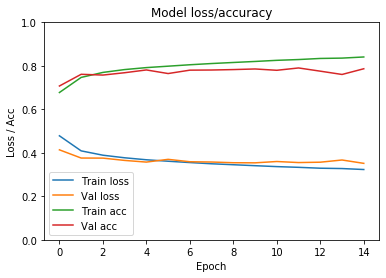

In [21]:
# Plot training vs validation loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.ylim([0, 1])
plt.title('Model loss/accuracy')
plt.ylabel('Loss / Acc')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss', 'Train acc', 'Val acc'])
plt.show()

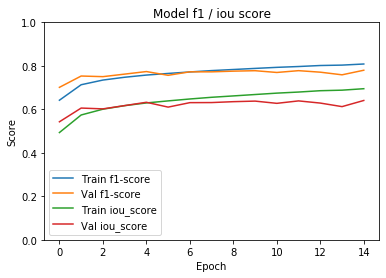

In [22]:
# Plot f1 score vs iou score
plt.plot(model_history.history['f1-score'])
plt.plot(model_history.history['val_f1-score'])
plt.plot(model_history.history['iou_score'])
plt.plot(model_history.history['val_iou_score'])
plt.ylim([0, 1])
plt.title('Model f1 / iou score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train f1-score', 'Val f1-score', 'Train iou_score', 'Val iou_score'])
plt.show()

## Testing

In [23]:
from keras.models import load_model
import cv2
import numpy as np
#model = load_model(checkpoint_path, custom_objects={'dice_loss': sm.losses.DiceLoss(class_weights=np.array([1, 1, 0.5]))})
model.load_weights('ml_model.h5')
def predict(model_checkpoint, image_path, out_file):
    img = pre_process_img(image_path, shape)
    #img = normalise_img(img)
    return model.predict(img)

In [24]:
# returns RGB
def convert_to_mask(img_rgb):
    mask = (img_rgb*255).astype(np.uint8)
    # correct the values if there
    mask[mask>127] = 255
    mask[mask<=127] = 0
    # find the indexes and change them to required
    indexes = np.where((mask==[255,0,0]).all(axis=2))
    mask[indexes] = [255, 255, 255]
    indexes = np.where((mask==[0,0,255]).all(axis=2))
    mask[indexes] = [255, 0, 0]
    indexes = np.where((mask==[0,255, 0]).all(axis=2))
    mask[indexes] = [0, 0, 255]
    
    return mask

In [25]:
imgs, msks = test_data_gen[0]
img_no = 0
img, msk = imgs[img_no], msks[img_no]
msk_pred = predict(checkpoint_path, img, msk)

### see actual images

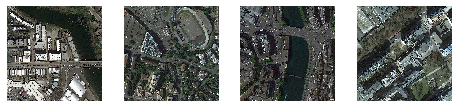

In [26]:
plot(imgs[0:4], 4)

## compare predicted mask with ground truth mask

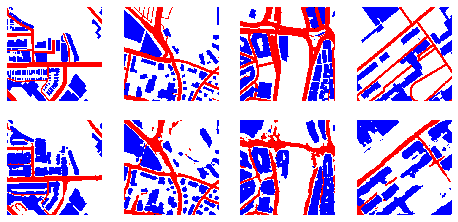

In [27]:
# see actual mask (1st row) vs predicted mask (predicted mask 2nd row)
plot(msks[0:4], 4, model.predict(imgs[0:4]),
     apply_fn=convert_to_mask)

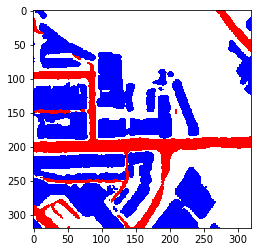

In [28]:
img = cv2.cvtColor(msk_pred[0],cv2.COLOR_BGR2RGB)
plt.imshow(convert_to_mask(img))

## See example of overlay with predicted mask vs overlay with ground-truth mask

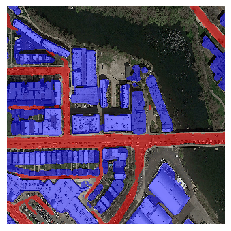

In [29]:
# overlay predicted
msk = cv2.cvtColor(msk_pred[0],cv2.COLOR_BGR2RGB)
img = cv2.cvtColor((imgs[img_no]*255).astype(np.uint8),cv2.COLOR_BGR2RGB)
overlay(img, convert_to_mask(msk), alpha=0.5)

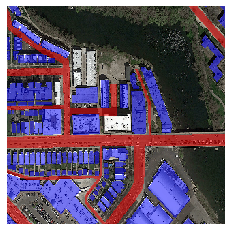

In [30]:
# overlay ground truth
img = cv2.cvtColor((imgs[img_no]*255).astype(np.uint8),cv2.COLOR_BGR2RGB)
msk = cv2.cvtColor(msks[img_no],cv2.COLOR_BGR2RGB)
overlay(img, convert_to_mask(msk), alpha=0.5)